<a href="https://colab.research.google.com/github/pravin-raut/MachineLearning/blob/Master/dissertation/Currency_%26_Oil_Forecast_v3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [250]:
!pip install pmdarima
!pip install quandl
!pip install yfinance

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

In [252]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


In [253]:
CurrentDate = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
CurrentDate
FirstDay='2019-01-01'


In [254]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

In [255]:

df_Oil_InUSD=getDataFromAPI("Nasdaq","OPEC/ORB",FirstDay,CurrentDate).reset_index()
df_Oil_InUSD['Date'] = pd.to_datetime(df_Oil_InUSD['Date']).dt.date
df_Oil_InUSD.set_index('Date', inplace=True)

df_Oil_InUSD=df_Oil_InUSD.asfreq('b')
df_Oil_InUSD['Original_Oil_Price']=df_Oil_InUSD.Value.fillna(method='bfill')
df_Oil_InUSD=df_Oil_InUSD[['Original_Oil_Price']]
df_Oil_InUSD

,Original_Oil_Price
Date,
2019-01-02,52.14
2019-01-03,52.93
2019-01-04,55.13
2019-01-07,56.42
2019-01-08,56.09
...,...
2023-07-07,78.43
2023-07-10,79.09
2023-07-11,79.67


In [256]:
df_USD_EUR=getDataFromAPI("YFinance","EURUSD=X",FirstDay,CurrentDate).reset_index()
df_USD_EUR['Date'] = pd.to_datetime(df_USD_EUR['Date']).dt.date
df_USD_EUR.set_index('Date', inplace=True)
df_USD_EUR=df_USD_EUR.asfreq('b')
df_USD_EUR.Close=df_USD_EUR.Close.fillna(method='bfill')
df_USD_EUR['Original_USD_EUR_Price']=df_USD_EUR[['Close']]
df_USD_EUR=df_USD_EUR[['Original_USD_EUR_Price']].iloc[1:]
df_USD_EUR = df_USD_EUR[df_USD_EUR.index.isin(df_Oil_InUSD.index)]
df_USD_EUR

,Original_USD_EUR_Price
Date,
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044
2019-01-08,1.147974
...,...
2023-07-07,1.089064
2023-07-10,1.096972
2023-07-11,1.100594


In [257]:
df_USD_EUR[df_USD_EUR.index.isin(df_Oil_InUSD.index)]


,Original_USD_EUR_Price
Date,
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044
2019-01-08,1.147974
...,...
2023-07-07,1.089064
2023-07-10,1.096972
2023-07-11,1.100594


In [258]:
def generate_shift_columns(df, column_name, min_shift, max_shift):
    for i in range(min_shift, max_shift + 1):
        df[f'{column_name}_shift{i}'] = df[column_name].shift(i)
    return df


In [259]:

df_USD_EUR['Original_USD_EUR_Price_MA_5'] = df_USD_EUR['Original_USD_EUR_Price'].rolling(window=5,min_periods=1).mean()
df_Oil_InUSD['Original_Oil_Price_MA_5'] = df_Oil_InUSD['Original_Oil_Price'].rolling(window=5,min_periods=1).mean()




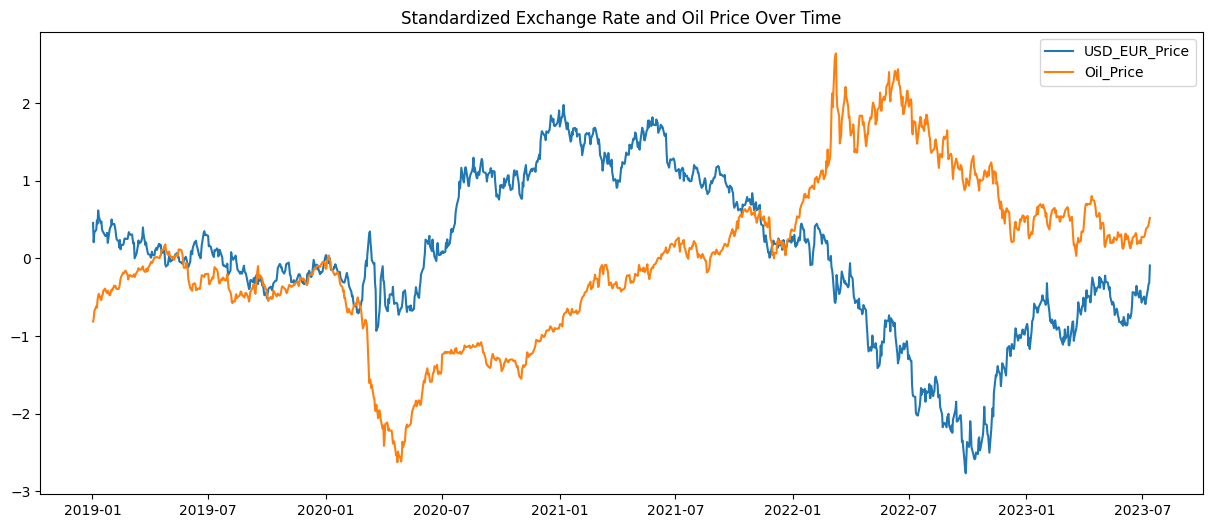

In [260]:
import matplotlib.pyplot as plt
import pandas as pd

df_USD_EUR['USD_EUR_Price_standardized'] = (df_USD_EUR['Original_USD_EUR_Price'] - df_USD_EUR['Original_USD_EUR_Price'].mean()) / df_USD_EUR['Original_USD_EUR_Price'].std()
df_Oil_InUSD['Oil_Price_standardized'] = (df_Oil_InUSD['Original_Oil_Price'] - df_Oil_InUSD['Original_Oil_Price'].mean()) / df_Oil_InUSD['Original_Oil_Price'].std()

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df_USD_EUR.index, df_USD_EUR['USD_EUR_Price_standardized'], label='USD_EUR_Price')
ax.plot(df_Oil_InUSD.index, df_Oil_InUSD['Oil_Price_standardized'], label='Oil_Price')

ax.set_title('Standardized Exchange Rate and Oil Price Over Time')
ax.legend()

plt.show()

In [261]:
df_oil_currency = df_Oil_InUSD.join(df_USD_EUR, how='inner')


In [262]:
from sklearn.preprocessing import StandardScaler
scaler_Cur = StandardScaler()
df_oil_currency[['Original_USD_EUR_Price_MA_5_Scaled']] = scaler_Cur.fit_transform(df_oil_currency[['Original_USD_EUR_Price_MA_5']])

scaler_Oil = StandardScaler()

df_oil_currency[['Original_Oil_Price_MA_5_Scaled']] = scaler_Oil.fit_transform(df_oil_currency[['Original_Oil_Price_MA_5']])


In [263]:
generate_shift_columns(df_oil_currency, 'Original_USD_EUR_Price_MA_5_Scaled', 1, 7)
generate_shift_columns(df_oil_currency, 'Original_Oil_Price_MA_5_Scaled', 1, 7)


,Original_Oil_Price,Original_Oil_Price_MA_5,Oil_Price_standardized,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,USD_EUR_Price_standardized,Original_USD_EUR_Price_MA_5_Scaled,Original_Oil_Price_MA_5_Scaled,Original_USD_EUR_Price_MA_5_Scaled_shift1,Original_USD_EUR_Price_MA_5_Scaled_shift2,...,Original_USD_EUR_Price_MA_5_Scaled_shift5,Original_USD_EUR_Price_MA_5_Scaled_shift6,Original_USD_EUR_Price_MA_5_Scaled_shift7,Original_Oil_Price_MA_5_Scaled_shift1,Original_Oil_Price_MA_5_Scaled_shift2,Original_Oil_Price_MA_5_Scaled_shift3,Original_Oil_Price_MA_5_Scaled_shift4,Original_Oil_Price_MA_5_Scaled_shift5,Original_Oil_Price_MA_5_Scaled_shift6,Original_Oil_Price_MA_5_Scaled_shift7
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,52.14,52.140,-0.812103,1.146171,1.146171,0.457695,0.458234,-0.812074,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,52.93,52.535,-0.776255,1.131811,1.138991,0.209528,0.333719,-0.794103,0.458234,NaN,...,NaN,NaN,NaN,-0.812074,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,55.13,53.400,-0.676424,1.139108,1.139030,0.335631,0.334395,-0.754749,0.333719,0.458234,...,NaN,NaN,NaN,-0.794103,-0.812074,NaN,NaN,NaN,NaN,NaN
2019-01-07,56.42,54.155,-0.617887,1.141044,1.139534,0.369099,0.343129,-0.720399,0.334395,0.333719,...,NaN,NaN,NaN,-0.754749,-0.794103,-0.812074,NaN,NaN,NaN,NaN
2019-01-08,56.09,54.542,-0.632862,1.147974,1.141222,0.488845,0.372402,-0.702792,0.343129,0.334395,...,NaN,NaN,NaN,-0.720399,-0.754749,-0.794103,-0.812074,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,78.43,76.978,0.380874,1.089064,1.089055,-0.529187,-0.532225,0.317959,-0.540066,-0.519515,...,-0.495645,-0.464128,-0.437493,0.297121,0.267822,0.247622,0.238249,0.224874,0.206675,0.229332
2023-07-10,79.09,77.572,0.410823,1.096972,1.090300,-0.392516,-0.510646,0.344983,-0.532225,-0.540066,...,-0.495356,-0.495645,-0.464128,0.317959,0.297121,0.267822,0.247622,0.238249,0.224874,0.206675
2023-07-11,79.67,78.270,0.437142,1.100594,1.092157,-0.329923,-0.478445,0.376740,-0.510646,-0.532225,...,-0.494448,-0.495356,-0.495645,0.344983,0.317959,0.297121,0.267822,0.247622,0.238249,0.224874


In [264]:
df_oil_currency.dropna(inplace=True)


In [265]:
# Define the start and end dates for train and test data
train_end_date = pd.to_datetime('2023-01-01')


In [266]:
train_oil_currency = df_oil_currency[df_oil_currency.index <= train_end_date]
test_oil_currency = df_oil_currency[df_oil_currency.index > train_end_date]
train_oil_currency.head(5)

,Original_Oil_Price,Original_Oil_Price_MA_5,Oil_Price_standardized,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,USD_EUR_Price_standardized,Original_USD_EUR_Price_MA_5_Scaled,Original_Oil_Price_MA_5_Scaled,Original_USD_EUR_Price_MA_5_Scaled_shift1,Original_USD_EUR_Price_MA_5_Scaled_shift2,...,Original_USD_EUR_Price_MA_5_Scaled_shift5,Original_USD_EUR_Price_MA_5_Scaled_shift6,Original_USD_EUR_Price_MA_5_Scaled_shift7,Original_Oil_Price_MA_5_Scaled_shift1,Original_Oil_Price_MA_5_Scaled_shift2,Original_Oil_Price_MA_5_Scaled_shift3,Original_Oil_Price_MA_5_Scaled_shift4,Original_Oil_Price_MA_5_Scaled_shift5,Original_Oil_Price_MA_5_Scaled_shift6,Original_Oil_Price_MA_5_Scaled_shift7
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-11,60.00,58.038,-0.455435,1.151013,1.148227,0.541364,0.493876,-0.543738,0.452587,0.370444,...,0.334395,0.333719,0.458234,-0.588051,-0.647469,-0.702792,-0.720399,-0.754749,-0.794103,-0.812074
2019-01-14,58.39,58.432,-0.528493,1.146014,1.149220,0.454971,0.511110,-0.525812,0.493876,0.452587,...,0.343129,0.334395,0.333719,-0.543738,-0.588051,-0.647469,-0.702792,-0.720399,-0.754749,-0.794103
2019-01-15,58.24,58.862,-0.535300,1.147289,1.149083,0.477010,0.508735,-0.506249,0.511110,0.493876,...,0.372402,0.343129,0.334395,-0.525812,-0.543738,-0.588051,-0.647469,-0.702792,-0.720399,-0.754749
2019-01-16,59.52,59.122,-0.477216,1.141683,1.148299,0.380131,0.495127,-0.494420,0.508735,0.511110,...,0.370444,0.372402,0.343129,-0.506249,-0.525812,-0.543738,-0.588051,-0.647469,-0.702792,-0.720399
2019-01-17,59.63,59.156,-0.472225,1.139809,1.145161,0.347747,0.440723,-0.492873,0.495127,0.508735,...,0.452587,0.370444,0.372402,-0.494420,-0.506249,-0.525812,-0.543738,-0.588051,-0.647469,-0.702792


In [267]:
import warnings
warnings.filterwarnings("ignore")


In [268]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
exogdata=['Original_Oil_Price_MA_5_Scaled_shift1','Original_Oil_Price_MA_5_Scaled_shift2','Original_Oil_Price_MA_5_Scaled_shift3','Original_Oil_Price_MA_5_Scaled_shift4','Original_Oil_Price_MA_5_Scaled_shift5']
oil_model=SARIMAX(train_oil_currency['Original_Oil_Price_MA_5_Scaled'],order=(5,1,5),exog=train_oil_currency[exogdata])
oil_model_fit=oil_model.fit(maxiter=1000)
oil_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:     Original_Oil_Price_MA_5_Scaled   No. Observations:                 1036
Model:                           SARIMAX(5, 1, 5)   Log Likelihood                2873.783
Date:                            Fri, 14 Jul 2023   AIC                          -5715.566
Time:                                    15:28:59   BIC                          -5636.491
Sample:                                01-11-2019   HQIC                         -5685.562
                                     - 12-30-2022                                         
Covariance Type:                              opg                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Original_Oil_Price_MA_5_Scaled_shift1     0.4923      0.283      1.742      0.082      -0.062       1.046
Original_Oil_Price_MA_5_Scaled_shift2     0.5758      0.293      1.965      0.049       0.001       1.150
Original_Oil_Price_MA_5_Scaled_shift3    -0.1219      0.139     -0.875      0.381      -0.395       0.151
Original_Oil_Price_MA_5_Scaled_shift4    -0.1122      0.128     -0.878      0.380      -0.363       0.138
Original_Oil_Price_MA_5_Scaled_shift5     0.1619      0.096      1.680      0.093      -0.027       0.351
ar.L1                                     0.6756      0.289      2.338      0.019       0.109       1.242
ar.L2                                    -0.4557      0.334     -1.364      0.173      -1.111       0.199
ar.L3                                     0.2921      0.215      1.359      0.174      -0.129       0.714
ar.L4                                    -0.0353      0.212     -0.166      0.868      -0.451       0.381
ar.L5                                    -0.0833      0.112     -0.740      0.459      -0.304       0.137
ma.L1                                    -0.0438      0.070     -0.628      0.530      -0.181       0.093
ma.L2                                     0.0272      0.069      0.392      0.695      -0.109       0.163
ma.L3                                    -0.0096      0.070     -0.136      0.891      -0.147       0.128
ma.L4                                    -0.0044      0.068     -0.064      0.949      -0.138       0.129
ma.L5                                    -0.9686      0.070    -13.840      0.000      -1.106      -0.831
sigma2                                    0.0002   1.61e-05     13.795      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4544.41
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [269]:
testing_data_forecast = oil_model_fit.get_forecast(steps=len(test_oil_currency), alpha=0.05,exog=test_oil_currency[exogdata])


# Create a new dataframe to hold the forecast
#test_oil_currency[['lower Cur predictions','Higher Cur predictions']] = testing_data_forecast.conf_int()

# Create a new column for the forecasted values
test_oil_currency['Cur_predictions_Oil_Day1'] =  testing_data_forecast.predicted_mean


test_oil_currency[['Original_Oil_Price_Predicted_Ahead_Day1']] = scaler_Oil.inverse_transform(test_oil_currency[['Cur_predictions_Oil_Day1']])


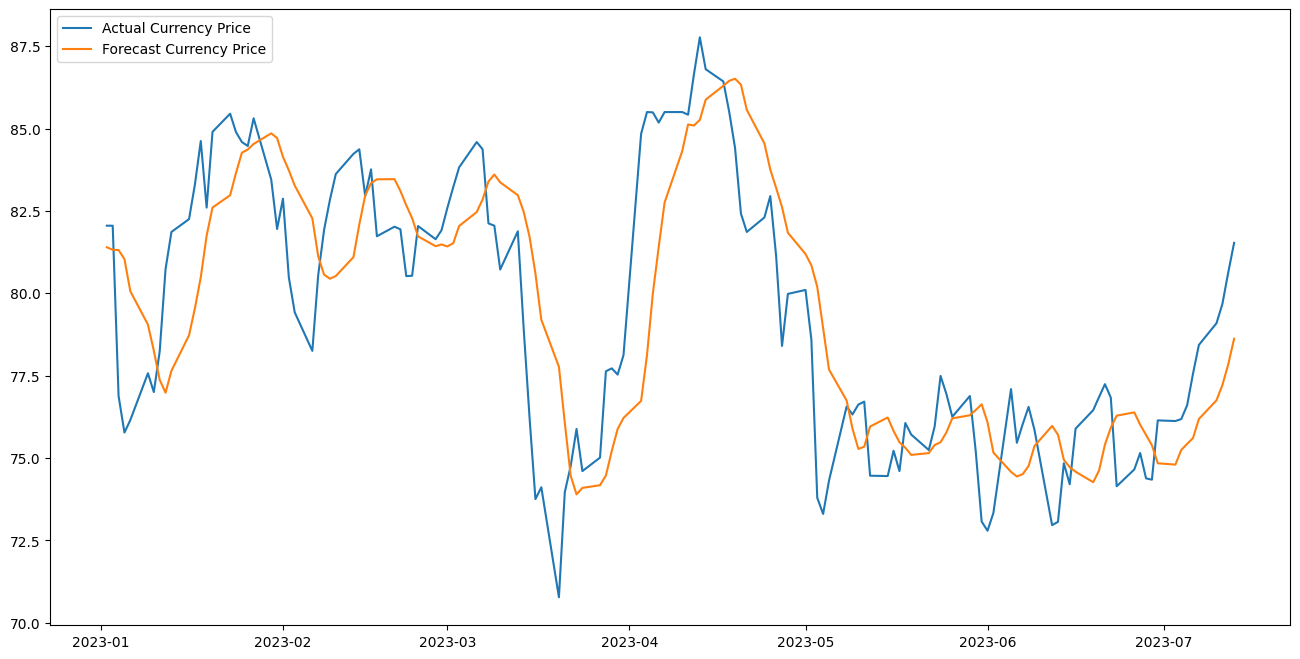

In [270]:
plt.figure(figsize=(16,8))
plt.plot(test_oil_currency['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(test_oil_currency['Original_Oil_Price_Predicted_Ahead_Day1'],label="Forecast Currency Price")
plt.legend(loc="upper left")
plt.show()


In [271]:


metrics = calculate_metrics(test_oil_currency['Original_Oil_Price'], test_oil_currency['Original_Oil_Price_Predicted_Ahead_Day1'])
metrics

{'Mean Absolute Error': 2.0871460781449223,
 'Mean Squared Error': 6.942601311668642,
 'Root Mean Squared Error': 2.6348816504102497,
 'Mean Absolute Percentage Error': 2.643296930777651}

#Day 5 Step Ahead Oil

In [272]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
exogdata=['Original_Oil_Price_MA_5_Scaled_shift6','Original_Oil_Price_MA_5_Scaled_shift7']

oil_model=SARIMAX(train_oil_currency['Original_Oil_Price_MA_5_Scaled'],order=(5,1,3),exog=train_oil_currency[exogdata])
oil_model_fit=oil_model.fit(maxiter=1000)
oil_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:     Original_Oil_Price_MA_5_Scaled   No. Observations:                 1036
Model:                           SARIMAX(5, 1, 3)   Log Likelihood                2802.538
Date:                            Fri, 14 Jul 2023   AIC                          -5583.076
Time:                                    15:29:30   BIC                          -5528.713
Sample:                                01-11-2019   HQIC                         -5562.449
                                     - 12-30-2022                                         
Covariance Type:                              opg                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Original_Oil_Price_MA_5_Scaled_shift6     0.2827      0.030      9.467      0.000       0.224       0.341
Original_Oil_Price_MA_5_Scaled_shift7     0.1910      0.030      6.405      0.000       0.133       0.250
ar.L1                                     0.8787      0.060     14.543      0.000       0.760       0.997
ar.L2                                    -0.3796      0.093     -4.068      0.000      -0.562      -0.197
ar.L3                                    -0.1905      0.090     -2.123      0.034      -0.366      -0.015
ar.L4                                     0.4989      0.061      8.112      0.000       0.378       0.619
ar.L5                                    -0.5388      0.030    -17.706      0.000      -0.598      -0.479
ma.L1                                     0.0891      0.058      1.535      0.125      -0.025       0.203
ma.L2                                     0.5542      0.037     14.794      0.000       0.481       0.628
ma.L3                                     0.7101      0.058     12.238      0.000       0.596       0.824
sigma2                                    0.0003   5.09e-06     50.582      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.55   Jarque-Bera (JB):              5317.10
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               2.67   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

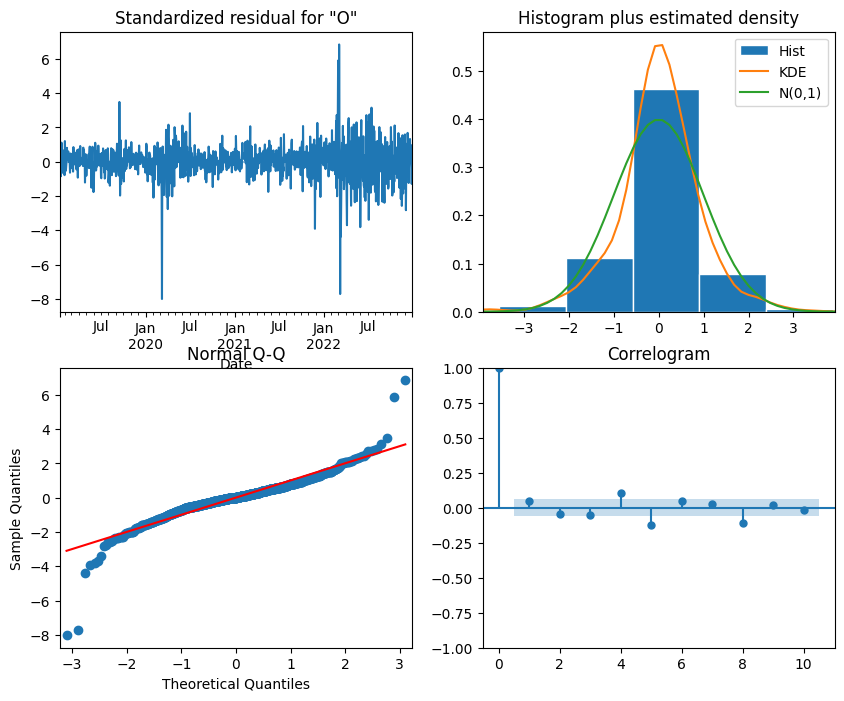

In [273]:
oil_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


In [274]:
test_oil_currency

,Original_Oil_Price,Original_Oil_Price_MA_5,Oil_Price_standardized,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,USD_EUR_Price_standardized,Original_USD_EUR_Price_MA_5_Scaled,Original_Oil_Price_MA_5_Scaled,Original_USD_EUR_Price_MA_5_Scaled_shift1,Original_USD_EUR_Price_MA_5_Scaled_shift2,...,Original_USD_EUR_Price_MA_5_Scaled_shift7,Original_Oil_Price_MA_5_Scaled_shift1,Original_Oil_Price_MA_5_Scaled_shift2,Original_Oil_Price_MA_5_Scaled_shift3,Original_Oil_Price_MA_5_Scaled_shift4,Original_Oil_Price_MA_5_Scaled_shift5,Original_Oil_Price_MA_5_Scaled_shift6,Original_Oil_Price_MA_5_Scaled_shift7,Cur_predictions_Oil_Day1,Original_Oil_Price_Predicted_Ahead_Day1
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,82.05,81.584,0.545141,1.070973,1.065543,-0.841807,-0.939968,0.527514,-0.954511,-0.974426,...,-1.009289,0.529152,0.522691,0.529516,0.505858,0.468551,0.431062,0.414228,0.518879,81.394206
2023-01-03,82.05,81.548,0.545141,1.067771,1.066292,-0.897140,-0.926965,0.525876,-0.939968,-0.954511,...,-1.022202,0.527514,0.529152,0.522691,0.529516,0.505858,0.468551,0.431062,0.515507,81.320094
2023-01-04,76.88,80.532,0.310539,1.054685,1.064486,-1.123280,-0.958287,0.479652,-0.926965,-0.939968,...,-0.993495,0.525876,0.527514,0.529152,0.522691,0.529516,0.505858,0.468551,0.515072,81.310533
2023-01-05,75.77,79.608,0.260169,1.060637,1.064028,-1.020439,-0.966225,0.437613,-0.958287,-0.926965,...,-0.984604,0.479652,0.525876,0.527514,0.529152,0.522691,0.529516,0.505858,0.502573,81.035808
2023-01-06,76.15,78.580,0.277413,1.052222,1.061258,-1.165855,-1.014272,0.390843,-0.966225,-0.958287,...,-0.981075,0.437613,0.479652,0.525876,0.527514,0.529152,0.522691,0.529516,0.458243,80.061429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,78.43,76.978,0.380874,1.089064,1.089055,-0.529187,-0.532225,0.317959,-0.540066,-0.519515,...,-0.437493,0.297121,0.267822,0.247622,0.238249,0.224874,0.206675,0.229332,0.281767,76.182501
2023-07-10,79.09,77.572,0.410823,1.096972,1.090300,-0.392516,-0.510646,0.344983,-0.532225,-0.540066,...,-0.464128,0.317959,0.297121,0.267822,0.247622,0.238249,0.224874,0.206675,0.307548,76.749167
2023-07-11,79.67,78.270,0.437142,1.100594,1.092157,-0.329923,-0.478445,0.376740,-0.510646,-0.532225,...,-0.495645,0.344983,0.317959,0.297121,0.267822,0.247622,0.238249,0.224874,0.328529,77.210333


In [275]:
testing_data_forecast = oil_model_fit.get_forecast(steps=len(test_oil_currency), alpha=0.05,exog=test_oil_currency[exogdata])


# Create a new dataframe to hold the forecast
#test_data_oil[['lower Cur predictions','Higher Cur predictions']] = testing_data_forecast.conf_int()

# Create a new column for the forecasted values
test_oil_currency['Cur_predictions_Oil_Day5'] =  testing_data_forecast.predicted_mean


test_oil_currency[['Original_Oil_Price_Predicted_Ahead_Day5']] = scaler_Oil.inverse_transform(test_oil_currency[['Cur_predictions_Oil_Day5']])
test_oil_currency

,Original_Oil_Price,Original_Oil_Price_MA_5,Oil_Price_standardized,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,USD_EUR_Price_standardized,Original_USD_EUR_Price_MA_5_Scaled,Original_Oil_Price_MA_5_Scaled,Original_USD_EUR_Price_MA_5_Scaled_shift1,Original_USD_EUR_Price_MA_5_Scaled_shift2,...,Original_Oil_Price_MA_5_Scaled_shift2,Original_Oil_Price_MA_5_Scaled_shift3,Original_Oil_Price_MA_5_Scaled_shift4,Original_Oil_Price_MA_5_Scaled_shift5,Original_Oil_Price_MA_5_Scaled_shift6,Original_Oil_Price_MA_5_Scaled_shift7,Cur_predictions_Oil_Day1,Original_Oil_Price_Predicted_Ahead_Day1,Cur_predictions_Oil_Day5,Original_Oil_Price_Predicted_Ahead_Day5
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,82.05,81.584,0.545141,1.070973,1.065543,-0.841807,-0.939968,0.527514,-0.954511,-0.974426,...,0.522691,0.529516,0.505858,0.468551,0.431062,0.414228,0.518879,81.394206,0.531200,81.665024
2023-01-03,82.05,81.548,0.545141,1.067771,1.066292,-0.897140,-0.926965,0.525876,-0.939968,-0.954511,...,0.529152,0.522691,0.529516,0.505858,0.468551,0.431062,0.515507,81.320094,0.528815,81.612604
2023-01-04,76.88,80.532,0.310539,1.054685,1.064486,-1.123280,-0.958287,0.479652,-0.926965,-0.939968,...,0.527514,0.529152,0.522691,0.529516,0.505858,0.468551,0.515072,81.310533,0.527531,81.584370
2023-01-05,75.77,79.608,0.260169,1.060637,1.064028,-1.020439,-0.966225,0.437613,-0.958287,-0.926965,...,0.525876,0.527514,0.529152,0.522691,0.529516,0.505858,0.502573,81.035808,0.537070,81.794051
2023-01-06,76.15,78.580,0.277413,1.052222,1.061258,-1.165855,-1.014272,0.390843,-0.966225,-0.958287,...,0.479652,0.525876,0.527514,0.529152,0.522691,0.529516,0.458243,80.061429,0.541143,81.883563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,78.43,76.978,0.380874,1.089064,1.089055,-0.529187,-0.532225,0.317959,-0.540066,-0.519515,...,0.267822,0.247622,0.238249,0.224874,0.206675,0.229332,0.281767,76.182501,0.408297,78.963623
2023-07-10,79.09,77.572,0.410823,1.096972,1.090300,-0.392516,-0.510646,0.344983,-0.532225,-0.540066,...,0.297121,0.267822,0.247622,0.238249,0.224874,0.206675,0.307548,76.749167,0.409113,78.981556
2023-07-11,79.67,78.270,0.437142,1.100594,1.092157,-0.329923,-0.478445,0.376740,-0.510646,-0.532225,...,0.317959,0.297121,0.267822,0.247622,0.238249,0.224874,0.328529,77.210333,0.416370,79.141082


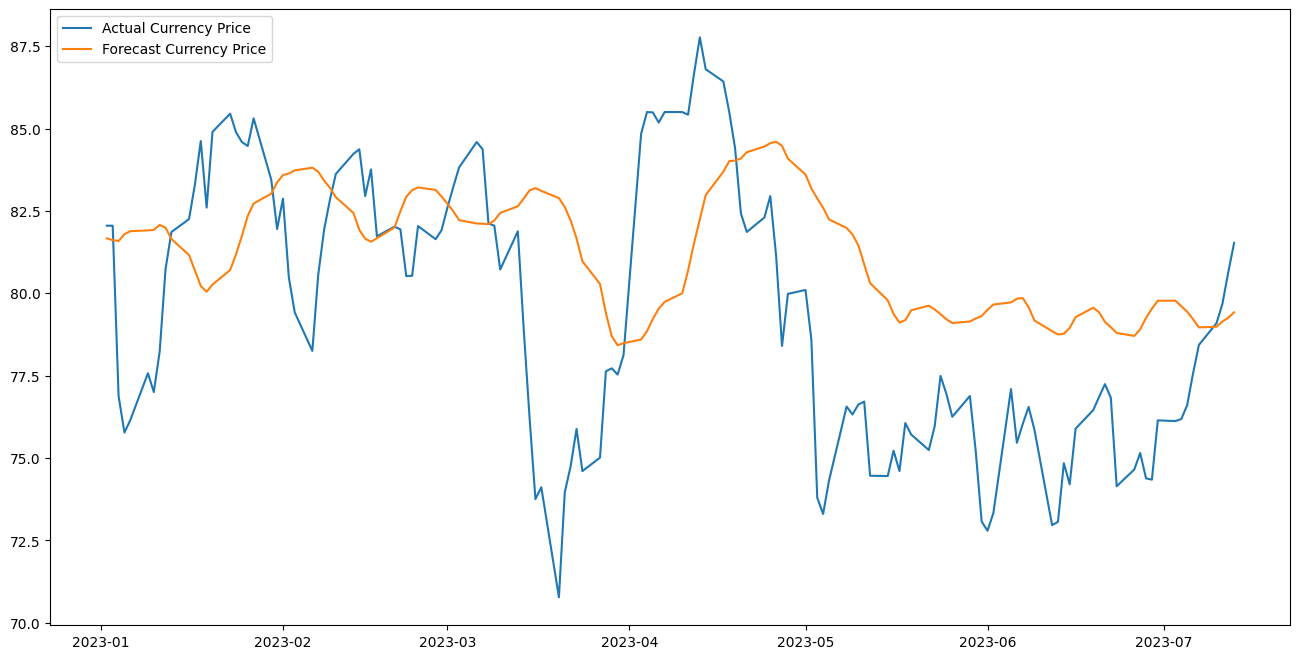

In [276]:
plt.figure(figsize=(16,8))
plt.plot(test_oil_currency['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(test_oil_currency['Original_Oil_Price_Predicted_Ahead_Day5'],label="Forecast Currency Price")
plt.legend(loc="upper left")
plt.show()


In [277]:


metrics = calculate_metrics(test_oil_currency['Original_Oil_Price'], test_oil_currency['Original_Oil_Price_Predicted_Ahead_Day5'])
metrics

{'Mean Absolute Error': 3.4978349100184762,
 'Mean Squared Error': 17.64767500011743,
 'Root Mean Squared Error': 4.200913591127224,
 'Mean Absolute Percentage Error': 4.497054121968491}

# CUrrency

In [278]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
exogdata=['Original_USD_EUR_Price_MA_5_Scaled_shift1','Original_USD_EUR_Price_MA_5_Scaled_shift2','Original_USD_EUR_Price_MA_5_Scaled_shift3','Original_USD_EUR_Price_MA_5_Scaled_shift4']

cur_model=SARIMAX(train_oil_currency['Original_USD_EUR_Price_MA_5_Scaled'],order=(3,1,3),exog=train_oil_currency[exogdata])
cur_model_fit=cur_model.fit(maxiter=1000)
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     Original_USD_EUR_Price_MA_5_Scaled   No. Observations:                 1036
Model:                               SARIMAX(3, 1, 3)   Log Likelihood                2637.563
Date:                                Fri, 14 Jul 2023   AIC                          -5253.126
Time:                                        15:30:16   BIC                          -5198.762
Sample:                                    01-11-2019   HQIC                         -5232.499
                                         - 12-30-2022                                         
Covariance Type:                                  opg                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Original_USD_EUR_Price_MA_5_Scaled_shift1     2.0044      0.083     24.268      0.000       1.842       2.166
Original_USD_EUR_Price_MA_5_Scaled_shift2    -1.8712      0.169    -11.074      0.000      -2.202      -1.540
Original_USD_EUR_Price_MA_5_Scaled_shift3     0.9544      0.146      6.559      0.000       0.669       1.240
Original_USD_EUR_Price_MA_5_Scaled_shift4    -0.2486      0.054     -4.632      0.000      -0.354      -0.143
ar.L1                                        -1.0233      0.059    -17.413      0.000      -1.138      -0.908
ar.L2                                        -0.7506      0.063    -11.847      0.000      -0.875      -0.626
ar.L3                                        -0.5235      0.032    -16.499      0.000      -0.586      -0.461
ma.L1                                        -0.0875      0.079     -1.110      0.267      -0.242       0.067
ma.L2                                         0.6634      0.048     13.779      0.000       0.569       0.758
ma.L3                                         0.5281      0.078      6.787      0.000       0.376       0.681
sigma2                                        0.0004    1.2e-05     29.591      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):               128.84
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [279]:
testing_data_forecast = cur_model_fit.get_forecast(steps=len(test_oil_currency), alpha=0.05,exog=test_oil_currency[exogdata])


# Create a new dataframe to hold the forecast
#test_oil_currency[['lower Cur predictions','Higher Cur predictions']] = testing_data_forecast.conf_int()

# Create a new column for the forecasted values
test_oil_currency['Cur_predictions_Day1'] =  testing_data_forecast.predicted_mean



test_oil_currency[['Original_USD_EUR_Price_Predicted_Ahead_Day1']] = scaler_Cur.inverse_transform(test_oil_currency[['Cur_predictions_Day1']])


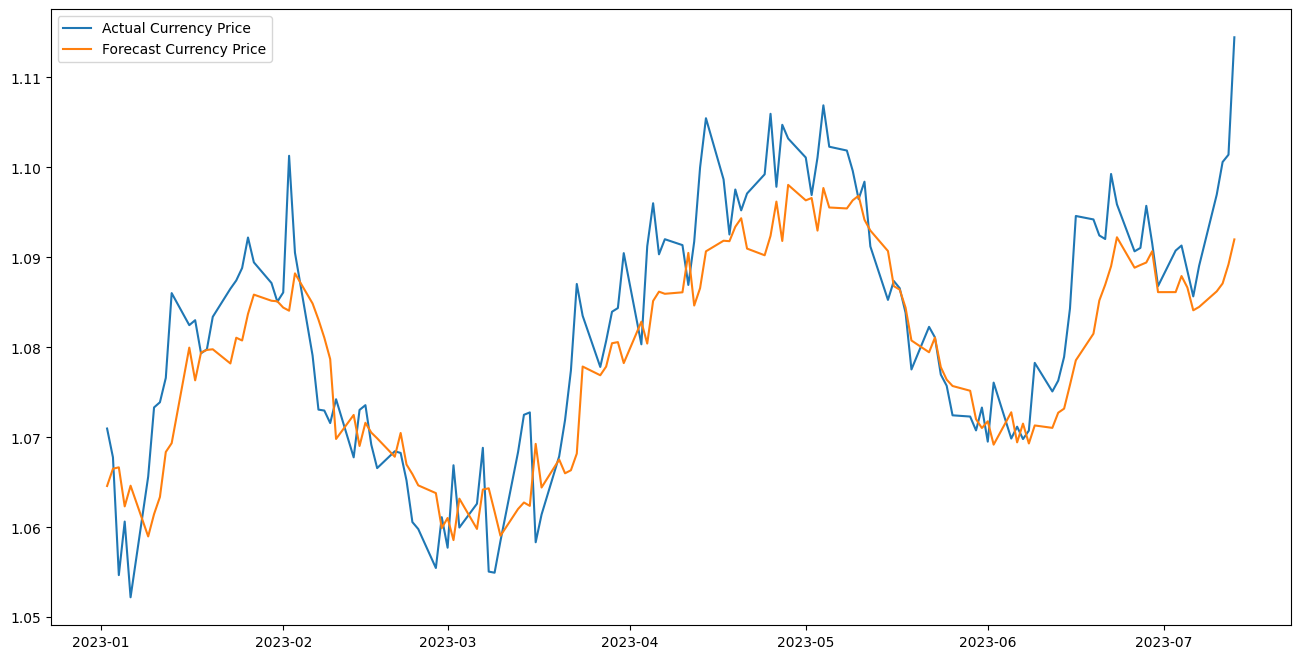

In [280]:
plt.figure(figsize=(16,8))
plt.plot(test_oil_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(test_oil_currency['Original_USD_EUR_Price_Predicted_Ahead_Day1'],label="Forecast Currency Price")
plt.legend(loc="upper left")
plt.show()


In [281]:

metrics = calculate_metrics(test_oil_currency['Original_USD_EUR_Price'], test_oil_currency['Original_USD_EUR_Price_Predicted_Ahead_Day1'])
metrics

{'Mean Absolute Error': 0.005568166598397344,
 'Mean Squared Error': 5.082275302622871e-05,
 'Root Mean Squared Error': 0.007129007857074413,
 'Mean Absolute Percentage Error': 0.5132796602631602}

In [282]:
exogdata=['Original_USD_EUR_Price_MA_5_Scaled_shift6','Original_USD_EUR_Price_MA_5_Scaled_shift7']

cur_model=SARIMAX(train_oil_currency['Original_USD_EUR_Price_MA_5_Scaled'],order=(5,1,3),exog=train_oil_currency[exogdata])
cur_model_fit=cur_model.fit(maxiter=1000)
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     Original_USD_EUR_Price_MA_5_Scaled   No. Observations:                 1036
Model:                               SARIMAX(5, 1, 3)   Log Likelihood                2643.304
Date:                                Fri, 14 Jul 2023   AIC                          -5264.607
Time:                                        15:30:53   BIC                          -5210.244
Sample:                                    01-11-2019   HQIC                         -5243.980
                                         - 12-30-2022                                         
Covariance Type:                                  opg                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Original_USD_EUR_Price_MA_5_Scaled_shift6     0.2528      0.040      6.301      0.000       0.174       0.331
Original_USD_EUR_Price_MA_5_Scaled_shift7     0.1097      0.031      3.490      0.000       0.048       0.171
ar.L1                                         0.8337      0.079     10.584      0.000       0.679       0.988
ar.L2                                        -0.3334      0.113     -2.947      0.003      -0.555      -0.112
ar.L3                                        -0.1796      0.103     -1.743      0.081      -0.381       0.022
ar.L4                                         0.4650      0.066      7.050      0.000       0.336       0.594
ar.L5                                        -0.4811      0.032    -15.046      0.000      -0.544      -0.418
ma.L1                                         0.0605      0.080      0.755      0.450      -0.096       0.217
ma.L2                                         0.5734      0.049     11.608      0.000       0.477       0.670
ma.L3                                         0.6739      0.080      8.436      0.000       0.517       0.830
sigma2                                        0.0004   1.17e-05     29.926      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):               179.13
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [283]:
testing_data_forecast = cur_model_fit.get_forecast(steps=len(test_oil_currency), alpha=0.05,exog=test_oil_currency[exogdata])


# Create a new dataframe to hold the forecast
#test_oil_currency[['lower Cur predictions','Higher Cur predictions']] = testing_data_forecast.conf_int()

# Create a new column for the forecasted values
test_oil_currency['Cur_predictions_Day5'] =  testing_data_forecast.predicted_mean



test_oil_currency[['Original_USD_EUR_Price_Predicted_Ahead_Day5']] = scaler_Cur.inverse_transform(test_oil_currency[['Cur_predictions_Day5']])


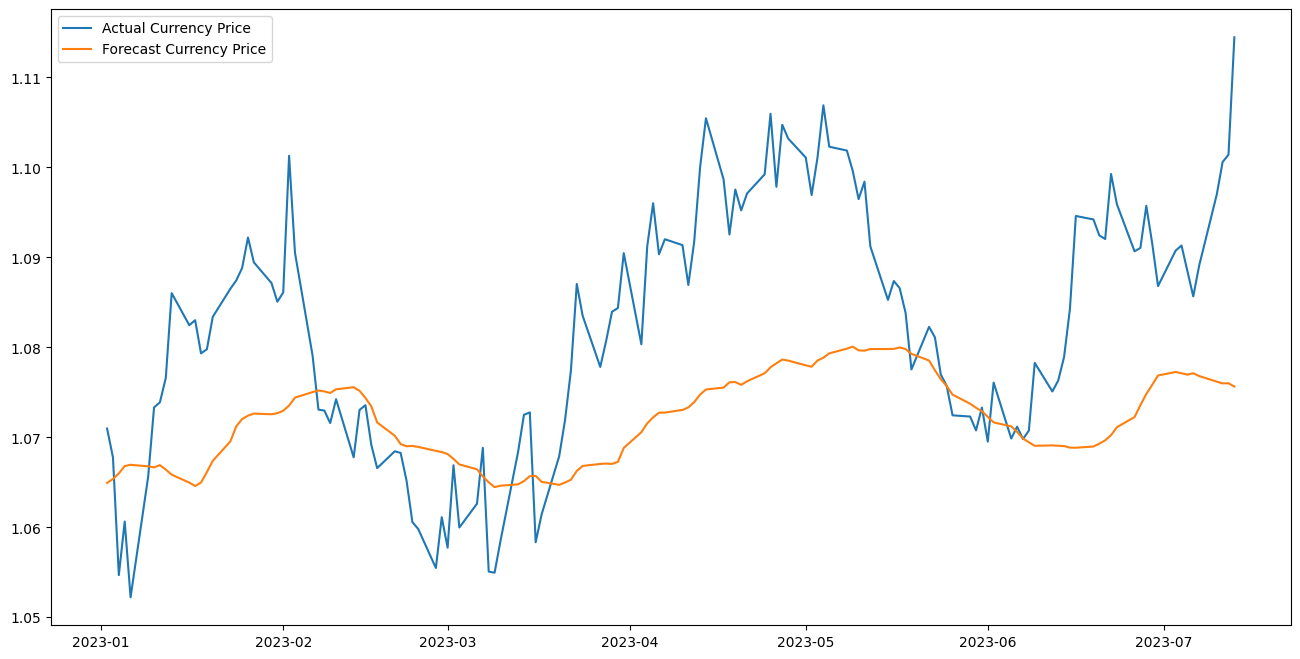

In [284]:
plt.figure(figsize=(16,8))
plt.plot(test_oil_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(test_oil_currency['Original_USD_EUR_Price_Predicted_Ahead_Day5'],label="Forecast Currency Price")
plt.legend(loc="upper left")
plt.show()


In [285]:

metrics = calculate_metrics(test_oil_currency['Original_USD_EUR_Price'], test_oil_currency['Original_USD_EUR_Price_Predicted_Ahead_Day5'])
metrics

{'Mean Absolute Error': 0.012626655521474673,
 'Mean Squared Error': 0.00023152369982870155,
 'Root Mean Squared Error': 0.015215902859465866,
 'Mean Absolute Percentage Error': 1.1591227757064801}

#CUrrency+ Oil

In [286]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
exogdata_cur_oil=['Original_USD_EUR_Price_MA_5_Scaled_shift1','Original_USD_EUR_Price_MA_5_Scaled_shift2','Original_USD_EUR_Price_MA_5_Scaled_shift3','Original_USD_EUR_Price_MA_5_Scaled_shift4','Original_Oil_Price_MA_5_Scaled']

cur_model=SARIMAX(train_oil_currency['Original_USD_EUR_Price_MA_5_Scaled'],order=(3,1,3),exog=train_oil_currency[exogdata_cur_oil])
cur_model_fit=cur_model.fit(maxiter=1000)
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     Original_USD_EUR_Price_MA_5_Scaled   No. Observations:                 1036
Model:                               SARIMAX(3, 1, 3)   Log Likelihood                2637.495
Date:                                Fri, 14 Jul 2023   AIC                          -5250.990
Time:                                        15:31:36   BIC                          -5191.684
Sample:                                    01-11-2019   HQIC                         -5228.487
                                         - 12-30-2022                                         
Covariance Type:                                  opg                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Original_USD_EUR_Price_MA_5_Scaled_shift1     2.0036      0.084     23.880      0.000       1.839       2.168
Original_USD_EUR_Price_MA_5_Scaled_shift2    -1.8730      0.170    -10.988      0.000      -2.207      -1.539
Original_USD_EUR_Price_MA_5_Scaled_shift3     0.9603      0.146      6.581      0.000       0.674       1.246
Original_USD_EUR_Price_MA_5_Scaled_shift4    -0.2527      0.054     -4.715      0.000      -0.358      -0.148
Original_Oil_Price_MA_5_Scaled                0.0044      0.007      0.590      0.555      -0.010       0.019
ar.L1                                        -1.0117      0.061    -16.517      0.000      -1.132      -0.892
ar.L2                                        -0.7402      0.064    -11.506      0.000      -0.866      -0.614
ar.L3                                        -0.5148      0.032    -16.032      0.000      -0.578      -0.452
ma.L1                                        -0.0983      0.082     -1.194      0.233      -0.260       0.063
ma.L2                                         0.6747      0.050     13.391      0.000       0.576       0.773
ma.L3                                         0.5184      0.082      6.324      0.000       0.358       0.679
sigma2                                        0.0004    1.2e-05     29.471      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):               129.86
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [287]:
exogdata_cur_oil_test=['Original_USD_EUR_Price_MA_5_Scaled_shift1','Original_USD_EUR_Price_MA_5_Scaled_shift2','Original_USD_EUR_Price_MA_5_Scaled_shift3','Original_USD_EUR_Price_MA_5_Scaled_shift4','Cur_predictions_Oil_Day1']
testing_data_forecast = cur_model_fit.get_forecast(steps=len(test_oil_currency), alpha=0.05,exog=test_oil_currency[exogdata_cur_oil_test])


# Create a new dataframe to hold the forecast
#test_oil_currency[['lower Cur predictions','Higher Cur predictions']] = testing_data_forecast.conf_int()

# Create a new column for the forecasted values
test_oil_currency['CurwithOil_predictions_Day1'] =  testing_data_forecast.predicted_mean



test_oil_currency[['Original_USD_EUR_Price_Predicted_WithOilDay1']] = scaler_Cur.inverse_transform(test_oil_currency[['CurwithOil_predictions_Day1']])


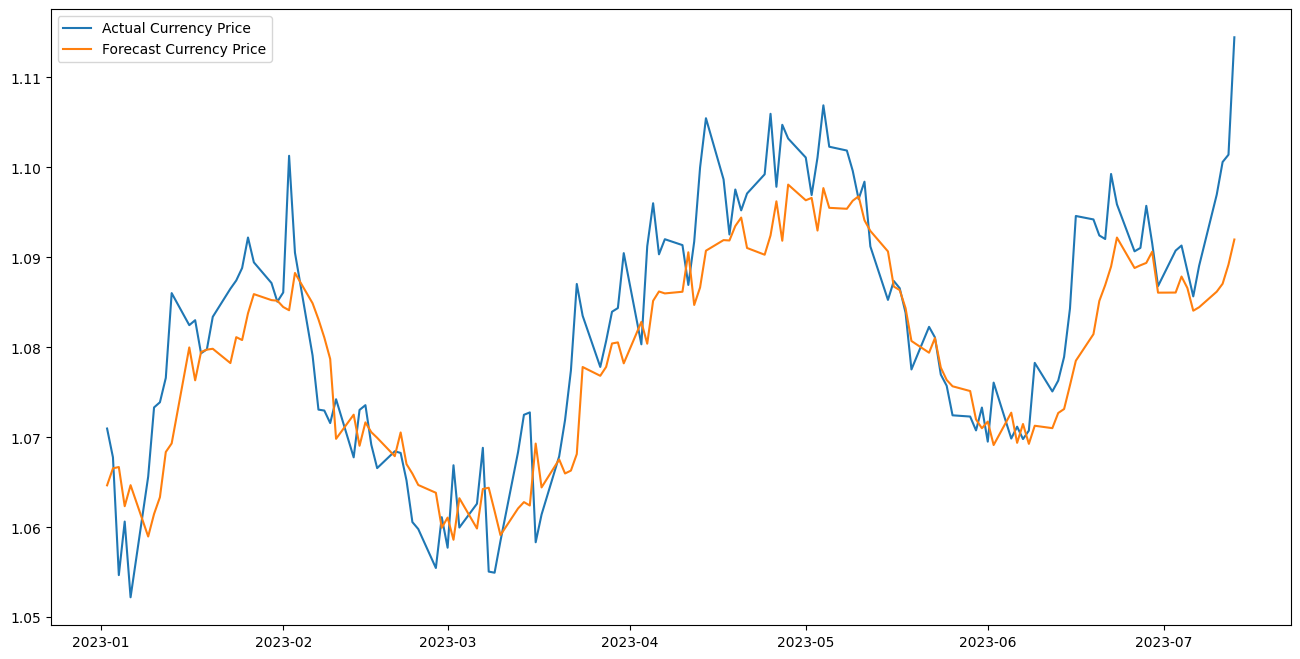

In [288]:
plt.figure(figsize=(16,8))
plt.plot(test_oil_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(test_oil_currency['Original_USD_EUR_Price_Predicted_WithOilDay1'],label="Forecast Currency Price")
plt.legend(loc="upper left")
plt.show()


In [289]:

metrics = calculate_metrics(test_oil_currency['Original_USD_EUR_Price'], test_oil_currency['Original_USD_EUR_Price_Predicted_WithOilDay1'])
metrics

{'Mean Absolute Error': 0.005570168421765595,
 'Mean Squared Error': 5.0857168116570054e-05,
 'Root Mean Squared Error': 0.007131421184909082,
 'Mean Absolute Percentage Error': 0.5134750048919678}

In [290]:
exogdata=['Original_USD_EUR_Price_MA_5_Scaled_shift6','Original_USD_EUR_Price_MA_5_Scaled_shift7','Original_Oil_Price_MA_5_Scaled']

cur_model=SARIMAX(train_oil_currency['Original_USD_EUR_Price_MA_5_Scaled'],order=(5,1,3),exog=train_oil_currency[exogdata])
cur_model_fit=cur_model.fit(maxiter=1000)
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     Original_USD_EUR_Price_MA_5_Scaled   No. Observations:                 1036
Model:                               SARIMAX(5, 1, 3)   Log Likelihood                2643.286
Date:                                Fri, 14 Jul 2023   AIC                          -5262.573
Time:                                        15:32:14   BIC                          -5203.267
Sample:                                    01-11-2019   HQIC                         -5240.070
                                         - 12-30-2022                                         
Covariance Type:                                  opg                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Original_USD_EUR_Price_MA_5_Scaled_shift6     0.2494      0.040      6.166      0.000       0.170       0.329
Original_USD_EUR_Price_MA_5_Scaled_shift7     0.1130      0.031      3.598      0.000       0.051       0.175
Original_Oil_Price_MA_5_Scaled               -0.0018      0.022     -0.084      0.933      -0.044       0.041
ar.L1                                         0.8257      0.076     10.806      0.000       0.676       0.975
ar.L2                                        -0.3204      0.109     -2.934      0.003      -0.534      -0.106
ar.L3                                        -0.1925      0.099     -1.942      0.052      -0.387       0.002
ar.L4                                         0.4730      0.063      7.493      0.000       0.349       0.597
ar.L5                                        -0.4815      0.031    -15.327      0.000      -0.543      -0.420
ma.L1                                         0.0680      0.078      0.876      0.381      -0.084       0.220
ma.L2                                         0.5686      0.048     11.835      0.000       0.474       0.663
ma.L3                                         0.6811      0.077      8.790      0.000       0.529       0.833
sigma2                                        0.0004   1.19e-05     29.409      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):               177.13
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [291]:
exogdata_cur_oil_test=['Original_USD_EUR_Price_MA_5_Scaled_shift6','Original_USD_EUR_Price_MA_5_Scaled_shift7','Cur_predictions_Oil_Day5']
testing_data_forecast = cur_model_fit.get_forecast(steps=len(test_oil_currency), alpha=0.05,exog=test_oil_currency[exogdata_cur_oil_test])


# Create a new dataframe to hold the forecast
#test_oil_currency[['lower Cur predictions','Higher Cur predictions']] = testing_data_forecast.conf_int()

# Create a new column for the forecasted values
test_oil_currency['CurwithOil_predictions_Day5'] =  testing_data_forecast.predicted_mean



test_oil_currency[['Original_USD_EUR_Price_Predicted_WithOilDay5']] = scaler_Cur.inverse_transform(test_oil_currency[['CurwithOil_predictions_Day5']])



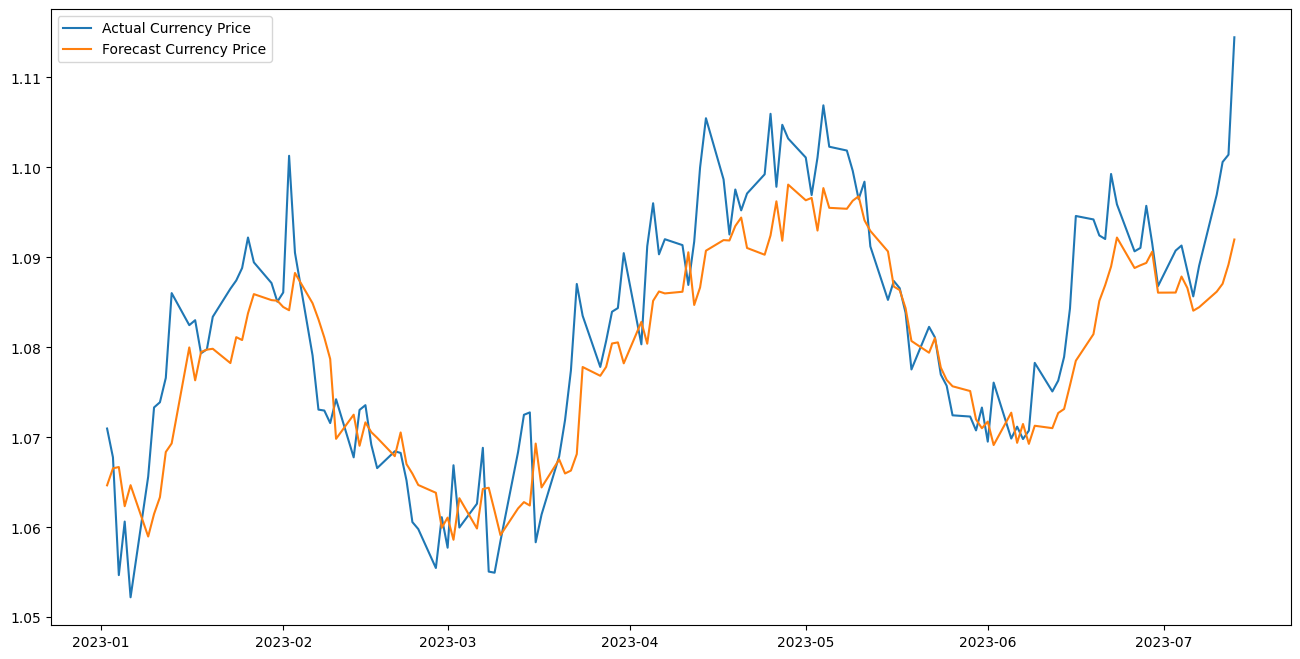

In [292]:

plt.figure(figsize=(16,8))
plt.plot(test_oil_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(test_oil_currency['Original_USD_EUR_Price_Predicted_WithOilDay1'],label="Forecast Currency Price")
plt.legend(loc="upper left")
plt.show()


In [293]:
metrics = calculate_metrics(test_oil_currency['Original_USD_EUR_Price'], test_oil_currency['Original_USD_EUR_Price_Predicted_WithOilDay1'])
metrics

{'Mean Absolute Error': 0.005570168421765595,
 'Mean Squared Error': 5.0857168116570054e-05,
 'Root Mean Squared Error': 0.007131421184909082,
 'Mean Absolute Percentage Error': 0.5134750048919678}